In [20]:
import h5py
import numpy as np
import os,random
from keras.layers import Input,Reshape,ZeroPadding2D,Conv2D,Dropout,Flatten,Dense,Activation,MaxPooling2D,AlphaDropout
from keras import layers
import keras.models as Model
from keras.regularizers import *
#from tensorflow.keras.optimizers import Adam
import seaborn as sns
import keras
import tensorrt as trt
import tensorflow as tf
import matplotlib.pyplot as plt
import gc
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

In [21]:
print(trt.__version__)

10.0.1


# **数据集处理**

In [22]:
############################################
#由于硬件限制，无法使用完整数据集，因此我从完整数据集中抽取出部分数据，并分割成24个部分
#每部分对应一种调制，有1200*26=31200条数据
#因此，目前数据集大小为748800*1024*2
############################################

for i in range(0,24): #24个数据集文件
    ########打开文件#######
    filename = '../ExtractDataset/part'+str(i) + '.h5'
    print(filename)
    f = h5py.File(filename,'r')
    ########读取数据#######
    X_data = f['X'][:]
    Y_data = f['Y'][:]
    Z_data = f['Z'][:]
    f.close()
    #########分割训练集和测试集#########
    #每读取到一个数据文件就直接分割为训练集和测试集，防止爆内存
    n_examples = X_data.shape[0]
    n_train = int(n_examples * 0.7)   #70%训练样本
    train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)#随机选取训练样本下标
    test_idx = list(set(range(0,n_examples))-set(train_idx))        #测试样本下标
    if i == 0:
        X_train = X_data[train_idx]
        Y_train = Y_data[train_idx]
        Z_train = Z_data[train_idx]
        X_test = X_data[test_idx]
        Y_test = Y_data[test_idx]
        Z_test = Z_data[test_idx]
    else:
        X_train = np.vstack((X_train, X_data[train_idx]))#np.vstack:将数据进行垂直堆叠（按行合并）
        Y_train = np.vstack((Y_train, Y_data[train_idx]))
        Z_train = np.vstack((Z_train, Z_data[train_idx]))
        X_test = np.vstack((X_test, X_data[test_idx]))
        Y_test = np.vstack((Y_test, Y_data[test_idx]))
        Z_test = np.vstack((Z_test, Z_data[test_idx]))
print('训练集X维度：',X_train.shape)
print('训练集Y维度：',Y_train.shape)
print('训练集Z维度：',Z_train.shape)
print('测试集X维度：',X_test.shape)
print('测试集Y维度：',Y_test.shape)
print('测试集Z维度：',Z_test.shape)

./ExtractDataset/part0.h5
./ExtractDataset/part1.h5
./ExtractDataset/part2.h5
./ExtractDataset/part3.h5
./ExtractDataset/part4.h5
./ExtractDataset/part5.h5
./ExtractDataset/part6.h5
./ExtractDataset/part7.h5
./ExtractDataset/part8.h5
./ExtractDataset/part9.h5
./ExtractDataset/part10.h5
./ExtractDataset/part11.h5
./ExtractDataset/part12.h5
./ExtractDataset/part13.h5
./ExtractDataset/part14.h5
./ExtractDataset/part15.h5
./ExtractDataset/part16.h5
./ExtractDataset/part17.h5
./ExtractDataset/part18.h5
./ExtractDataset/part19.h5
./ExtractDataset/part20.h5
./ExtractDataset/part21.h5
./ExtractDataset/part22.h5
./ExtractDataset/part23.h5
训练集X维度： (524160, 1024, 2)
训练集Y维度： (524160, 24)
训练集Z维度： (524160, 1)
测试集X维度： (224640, 1024, 2)
测试集Y维度： (224640, 24)
测试集Z维度： (224640, 1)


snr: [30]
Y [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


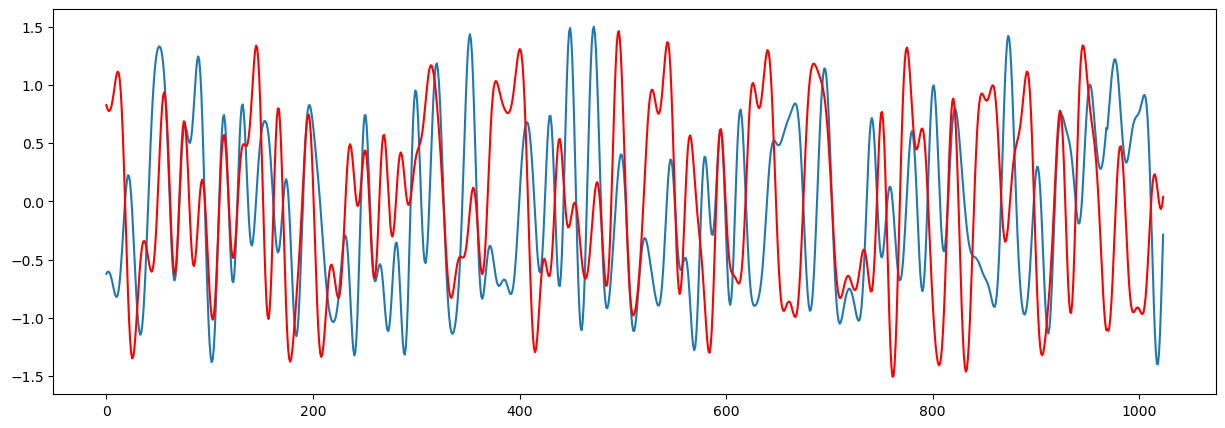

In [23]:
##查看数据是否正常
sample_idx = 520329 #随机下标
print('snr:',Z_train[sample_idx])
print('Y',Y_train[sample_idx])
plt_data = X_train[sample_idx].T
plt.figure(figsize=(15,5))
plt.plot(plt_data[0])
plt.plot(plt_data[1],color = 'red')
plt.show()

# **建立模型**

In [24]:
"""建立模型"""
classes = ['OOK',
           '4ASK',
           '8ASK',
           'BPSK',
           'QPSK',
           '8PSK',
           '16PSK',
           '32PSK',
           '16APSK',
           '32APSK',
           '64APSK',
           '128APSK',
           '16QAM',
           '32QAM',
           '64QAM',
           '128QAM',
           '256QAM',
           'AM-SSB-WC',
           'AM-SSB-SC',
           'AM-DSB-WC',
           'AM-DSB-SC',
           'FM',
           'GMSK',
           'OQPSK']
data_format = 'channels_first'

def residual_stack(Xm,kennel_size,Seq,pool_size):
    #1*1 Conv Linear
    #这里32是一个常见的卷积核数量，一般认为可以在特征提取和计算资源之间取得平衡
    Xm = Conv2D(32, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    #Residual Unit 1
    Xm_shortcut = Xm   #保存输入以便于跳跃连接
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv3", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    
    # 添加跳跃连接，将输入与卷积层输出相加
    Xm = layers.add([Xm,Xm_shortcut])  
    Xm = Activation("relu")(Xm)
    #Residual Unit 2
    Xm_shortcut = Xm
    Xm = Conv2D(32, kennel_size, padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = Conv2D(32, kennel_size, padding='same', name=Seq+"_conv5", kernel_initializer='glorot_normal',data_format=data_format)(Xm)
    Xm = layers.add([Xm,Xm_shortcut])
    Xm = Activation("relu")(Xm)
    #MaxPooling
    Xm = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='valid', data_format=data_format)(Xm)
    return Xm


in_shp = X_train.shape[1:]   #每个样本的维度[1024,2]
#input layer
Xm_input = Input(in_shp)
Xm = Reshape([1,1024,2], input_shape=in_shp)(Xm_input)
#Residual Srack
Xm = residual_stack(Xm,kennel_size=(3,2),Seq="ReStk0",pool_size=(2,2))   #shape:(512,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk1",pool_size=(2,1))   #shape:(256,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk2",pool_size=(2,1))   #shape:(128,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk3",pool_size=(2,1))   #shape:(64,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk4",pool_size=(2,1))   #shape:(32,1,32)
Xm = residual_stack(Xm,kennel_size=(3,1),Seq="ReStk5",pool_size=(2,1))   #shape:(16,1,32)

#############################################################################
#      多次尝试发现减少一层全连接层能使loss下降更快
#      将AlphaDropout设置为0.3似乎比0.5效果更好
#############################################################################
#Full Con 1
Xm = Flatten(data_format=data_format)(Xm)
Xm = Dense(128, activation='selu', kernel_initializer='glorot_normal', name="dense1")(Xm)
Xm = AlphaDropout(0.3)(Xm)
#Full Con 2
Xm = Dense(len(classes), kernel_initializer='glorot_normal', name="dense2")(Xm)
#SoftMax
Xm = Activation('softmax')(Xm)
#Create Model
model = Model.Model(inputs=Xm_input,outputs=Xm)
adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1024, 2)]    0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 1024, 2)   0           ['input_2[0][0]']                
                                                                                                  
 ReStk0_conv1 (Conv2D)          (None, 32, 1024, 2)  64          ['reshape_1[0][0]']              
                                                                                                  
 ReStk0_conv2 (Conv2D)          (None, 32, 1024, 2)  6176        ['ReStk0_conv1[0][0]']           
                                                                                            

In [25]:
# 检查GPU
#print(tf.test.gpu_device_name())

# 检查数据形状
#print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# 检查是否有 None 值
#print(X_train is None, Y_train is None, X_test is None, Y_test is None)
# 调试信息
print(f"X_train type: {type(X_train)}, shape: {X_train.shape}")
print(f"Y_train type: {type(Y_train)}, shape: {Y_train.shape}")
print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")
print(f"Y_test type: {type(Y_test)}, shape: {Y_test.shape}")

# 确保数据不为 None
assert X_train is not None, "X_train is None"
assert Y_train is not None, "Y_train is None"
assert X_test is not None, "X_test is None"
assert Y_test is not None, "Y_test is None"





X_train type: <class 'numpy.ndarray'>, shape: (524160, 1024, 2)
Y_train type: <class 'numpy.ndarray'>, shape: (524160, 24)
X_test type: <class 'numpy.ndarray'>, shape: (224640, 1024, 2)
Y_test type: <class 'numpy.ndarray'>, shape: (224640, 24)


In [28]:
print(type(X_train))

<class 'numpy.ndarray'>


In [29]:
filepath = '/home/cjj/ResNet-for-Radio-Recognition-master/Models/ResNet_Model_72w.h5.keras'
print("X_train is None:", X_train is None)
print("Y_train is None:", Y_train is None)
print("X_test is None:", X_test is None)
print("Y_test is None:", Y_test is None)
print("filepath is None:", filepath is None)


X_train is None: False
Y_train is None: False
X_test is None: False
Y_test is None: False
filepath is None: False


# **训练**

In [30]:
"""训练模型"""
#############################################################################
#      当val_loss连续10次迭代不再减小或总迭代次数大于100时停止
#      将最小验证损失的模型保存
#############################################################################
print(tf.test.gpu_device_name())

history = model.fit(X_train,
    Y_train,
    batch_size=1000,
    epochs=100,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.3,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)


Epoch 1/100


2024-06-01 09:27:45.131026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-01 09:27:45.131120: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


525/525 - 1117s - loss: 2.1910 - val_loss: 1.8752 - 1117s/epoch - 2s/step
Epoch 2/100
525/525 - 1116s - loss: 1.8433 - val_loss: 1.9324 - 1116s/epoch - 2s/step
Epoch 3/100
525/525 - 1116s - loss: 1.8087 - val_loss: 1.8198 - 1116s/epoch - 2s/step
Epoch 4/100
525/525 - 1117s - loss: 1.7551 - val_loss: 1.7261 - 1117s/epoch - 2s/step
Epoch 5/100
525/525 - 1115s - loss: 1.7249 - val_loss: 1.7325 - 1115s/epoch - 2s/step
Epoch 6/100
525/525 - 1116s - loss: 1.8480 - val_loss: 1.8434 - 1116s/epoch - 2s/step
Epoch 7/100
525/525 - 1119s - loss: 1.7405 - val_loss: 1.7088 - 1119s/epoch - 2s/step
Epoch 8/100
525/525 - 1120s - loss: 1.6695 - val_loss: 1.6786 - 1120s/epoch - 2s/step
Epoch 9/100
525/525 - 1109s - loss: 1.7423 - val_loss: 1.8033 - 1109s/epoch - 2s/step
Epoch 10/100
525/525 - 1117s - loss: 1.6617 - val_loss: 1.6025 - 1117s/epoch - 2s/step
Epoch 11/100
525/525 - 1110s - loss: 1.6270 - val_loss: 1.5993 - 1110s/epoch - 2s/step
Epoch 12/100
525/525 - 1114s - loss: 1.5722 - val_loss: 1.6097 -

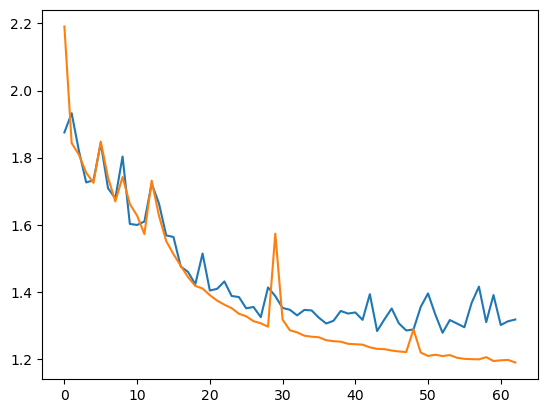

In [31]:
val_loss_list = history.history['val_loss']
loss_list = history.history['loss']
plt.plot(range(len(loss_list)),val_loss_list)
plt.plot(range(len(loss_list)),loss_list)
plt.show()

In [32]:
# ##########从loss走势来看，预计loss还能继续下降，故再训练一次#######
# history = model.fit(X_train,
#     Y_train,
#     batch_size=1000,
#     epochs=100,
#     verbose=2,
#     validation_data=(X_test, Y_test),
#     #validation_split = 0.3,
#     callbacks = [
#         keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
#         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
#     ])

# # we re-load the best weights once training is finished
# model.load_weights(filepath)

# **测试**

220/220 [==============================] - 134s 608ms/step


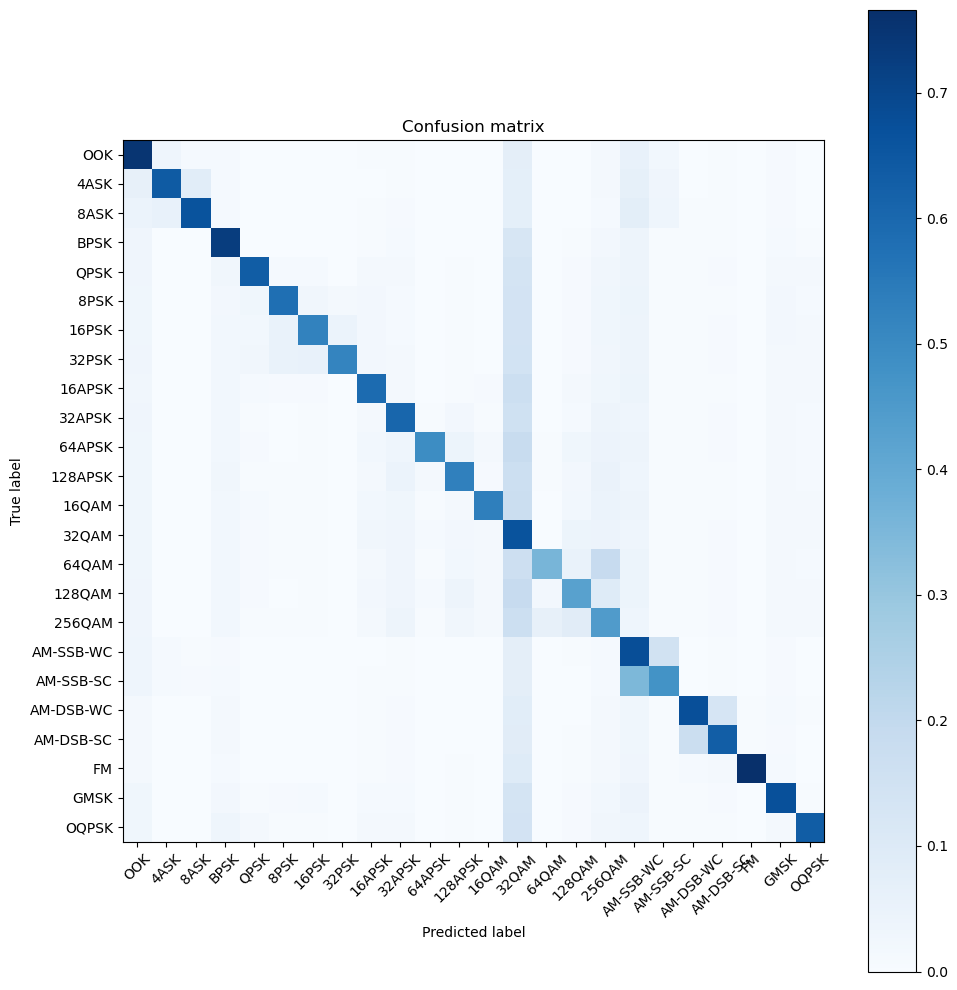

In [33]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# 绘制混淆矩阵
batch_size = 1024
test_Y_hat = model.predict(X_test, batch_size=1024)
#初始化混淆矩阵
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [34]:
for i in range(len(confnorm)):
    print(classes[i],confnorm[i,i])

OOK 0.7489316239316239
4ASK 0.6398504273504273
8ASK 0.6622863247863248
BPSK 0.7254273504273504
QPSK 0.6339743589743589
8PSK 0.5791666666666667
16PSK 0.5225427350427351
32PSK 0.5151709401709401
16APSK 0.5897435897435898
32APSK 0.6069444444444444
64APSK 0.4907051282051282
128APSK 0.5283119658119658
16QAM 0.5321581196581197
32QAM 0.6636752136752136
64QAM 0.3579059829059829
128QAM 0.4270299145299145
256QAM 0.44497863247863245
AM-SSB-WC 0.677457264957265
AM-SSB-SC 0.47307692307692306
AM-DSB-WC 0.6736111111111112
AM-DSB-SC 0.6289529914529914
FM 0.7658119658119659
GMSK 0.6708333333333333
OQPSK 0.6332264957264957


267/267 [==============================] - 7s 26ms/step
Overall Accuracy -20:  0.03794355310926338
273/273 [==============================] - 7s 26ms/step
Overall Accuracy -18:  0.04205339750200527
275/275 [==============================] - 7s 26ms/step
Overall Accuracy -16:  0.0462868190606164
271/271 [==============================] - 7s 26ms/step
Overall Accuracy -14:  0.05259507571379032
273/273 [==============================] - 7s 26ms/step
Overall Accuracy -12:  0.06406142562457025
272/272 [==============================] - 7s 26ms/step
Overall Accuracy -10:  0.09430481899930827
271/271 [==============================] - 7s 26ms/step
Overall Accuracy -8:  0.14661740937427845
269/269 [==============================] - 7s 26ms/step
Overall Accuracy -6:  0.21564974382859806
271/271 [==============================] - 7s 26ms/step
Overall Accuracy -4:  0.30437297547431746
276/276 [==============================] - 7s 26ms/step
Overall Accuracy -2:  0.4010434388113871
273/273 [=======

/tmp/ipykernel_70489/2932199693.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


268/268 [==============================] - 7s 26ms/step
Overall Accuracy 2:  0.6028691392582225
266/266 [==============================] - 7s 26ms/step
Overall Accuracy 4:  0.7220195363069318
270/270 [==============================] - 7s 25ms/step
Overall Accuracy 6:  0.8316350162112089
268/268 [==============================] - 7s 25ms/step
Overall Accuracy 8:  0.9032784972581962
271/271 [==============================] - 7s 25ms/step
Overall Accuracy 10:  0.9342820779821821
270/270 [==============================] - 7s 25ms/step
Overall Accuracy 12:  0.9488399071925754
268/268 [==============================] - 7s 25ms/step
Overall Accuracy 14:  0.9437441643323996
272/272 [==============================] - 7s 25ms/step
Overall Accuracy 16:  0.9538496950166878
269/269 [==============================] - 7s 25ms/step
Overall Accuracy 18:  0.9499359646058912
268/268 [==============================] - 7s 25ms/step
Overall Accuracy 20:  0.9512252042007001
273/273 [=========================

<Figure size 640x480 with 0 Axes>

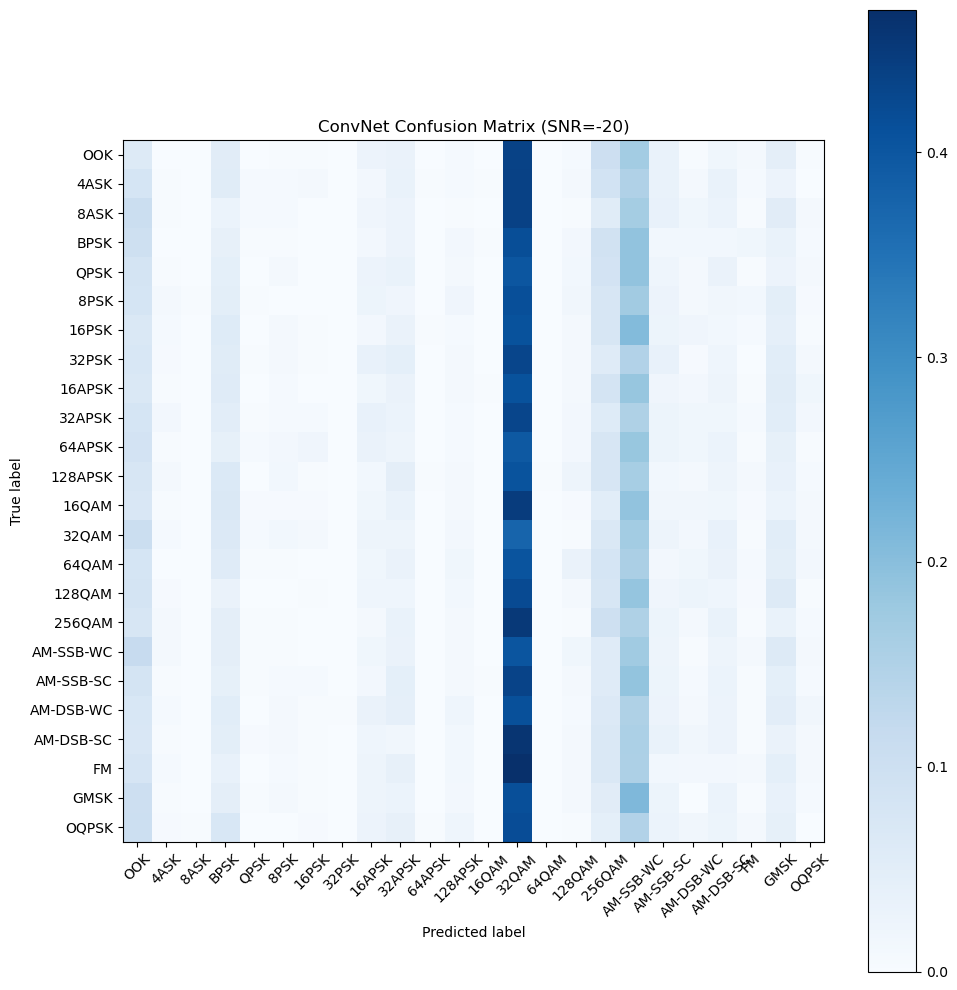

<Figure size 640x480 with 0 Axes>

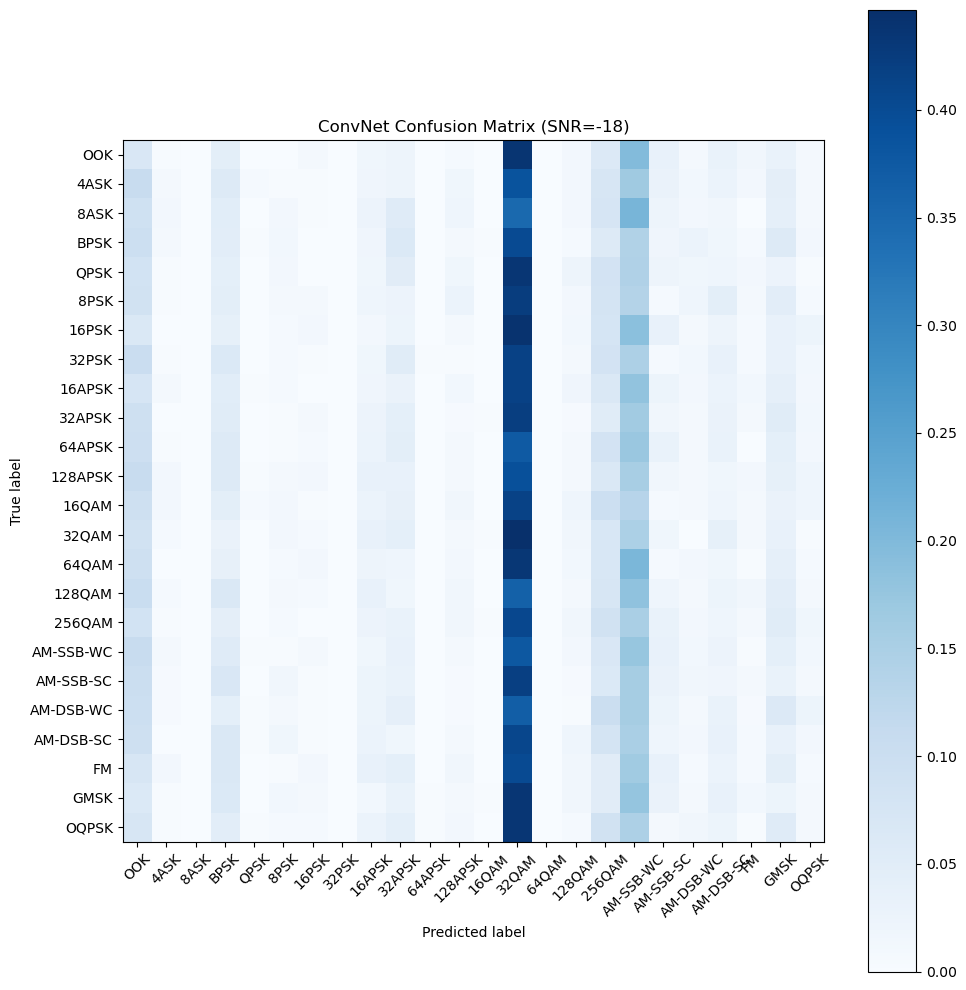

<Figure size 640x480 with 0 Axes>

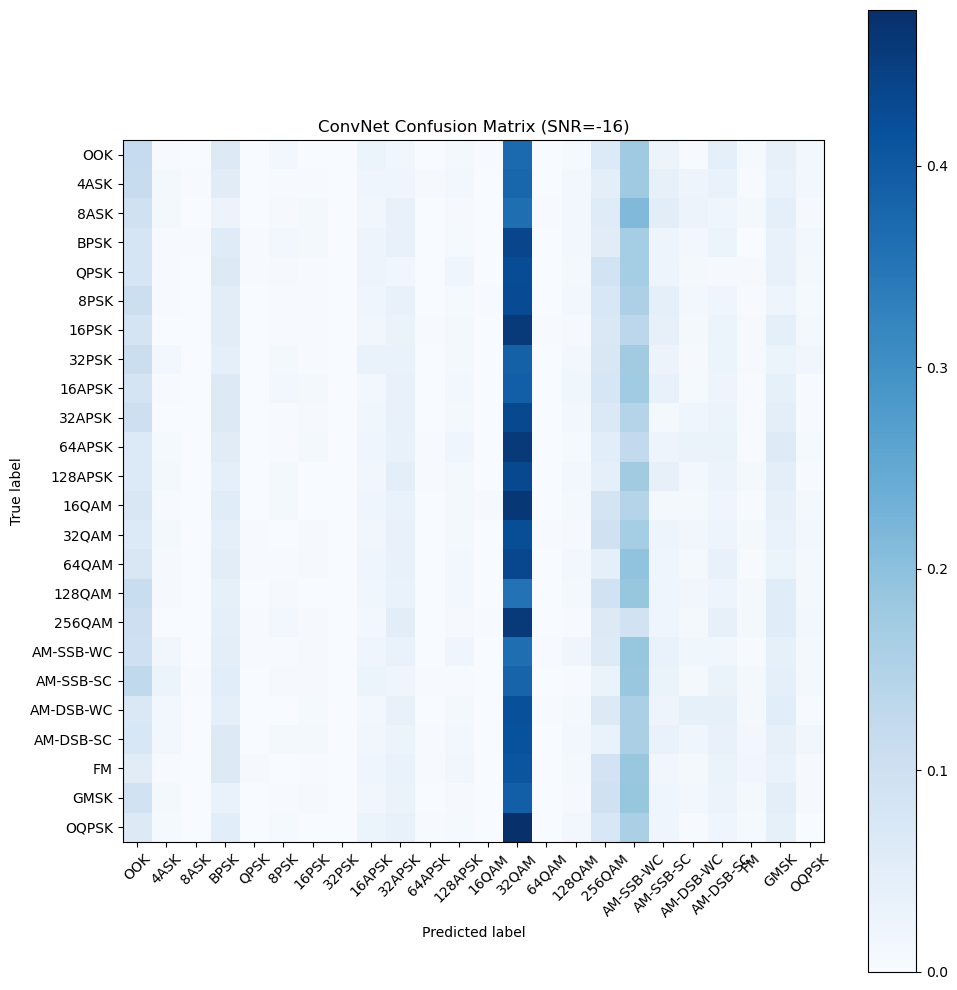

<Figure size 640x480 with 0 Axes>

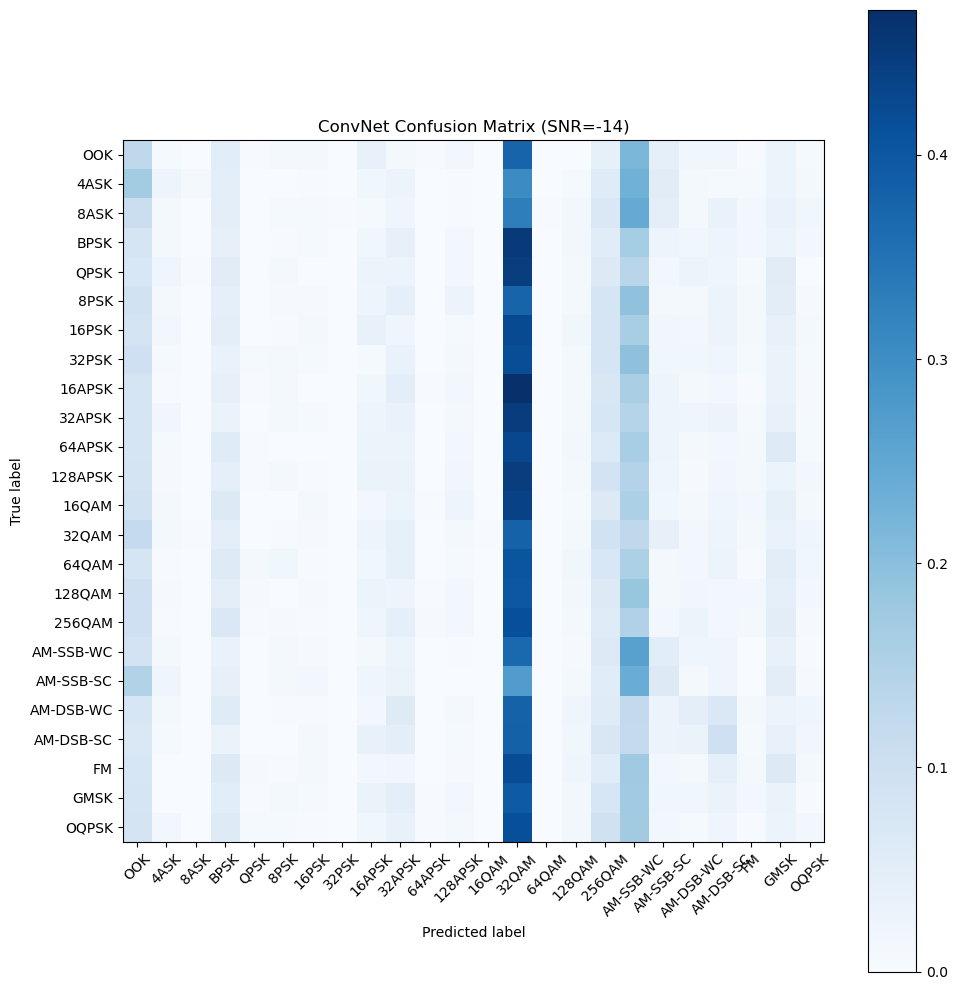

<Figure size 640x480 with 0 Axes>

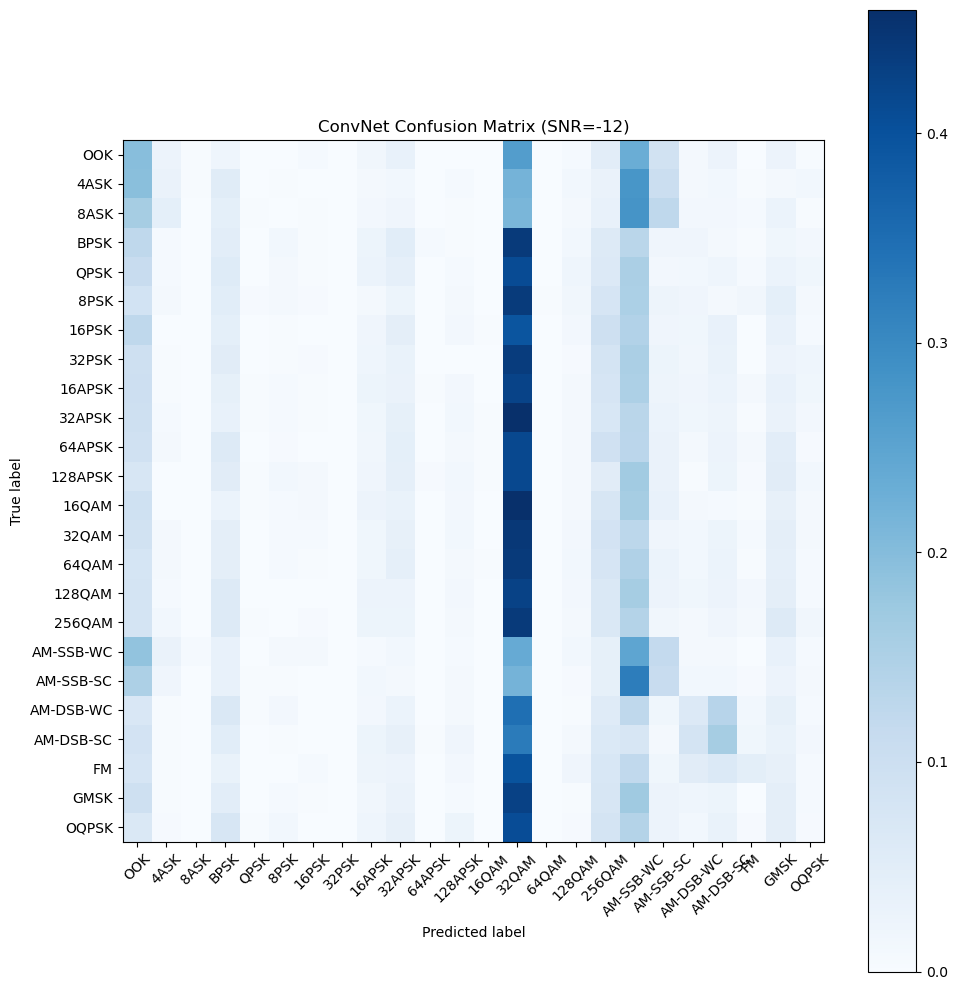

<Figure size 640x480 with 0 Axes>

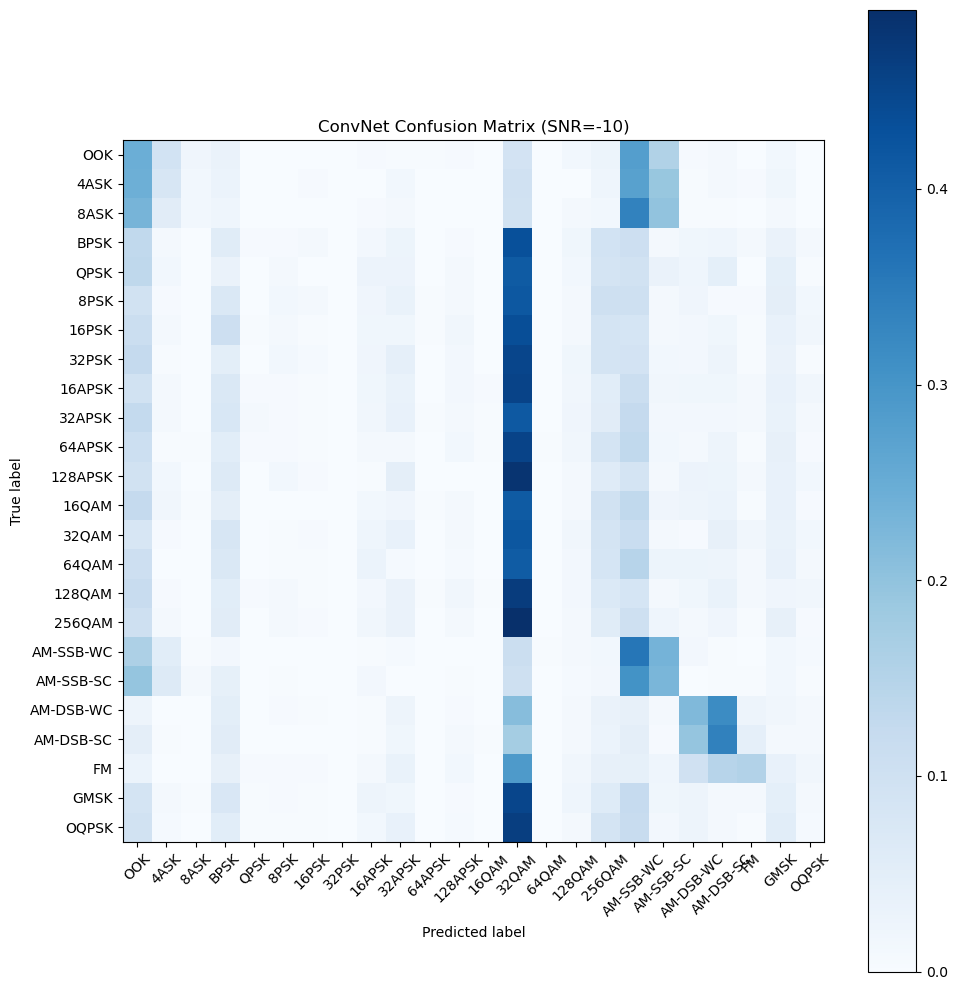

<Figure size 640x480 with 0 Axes>

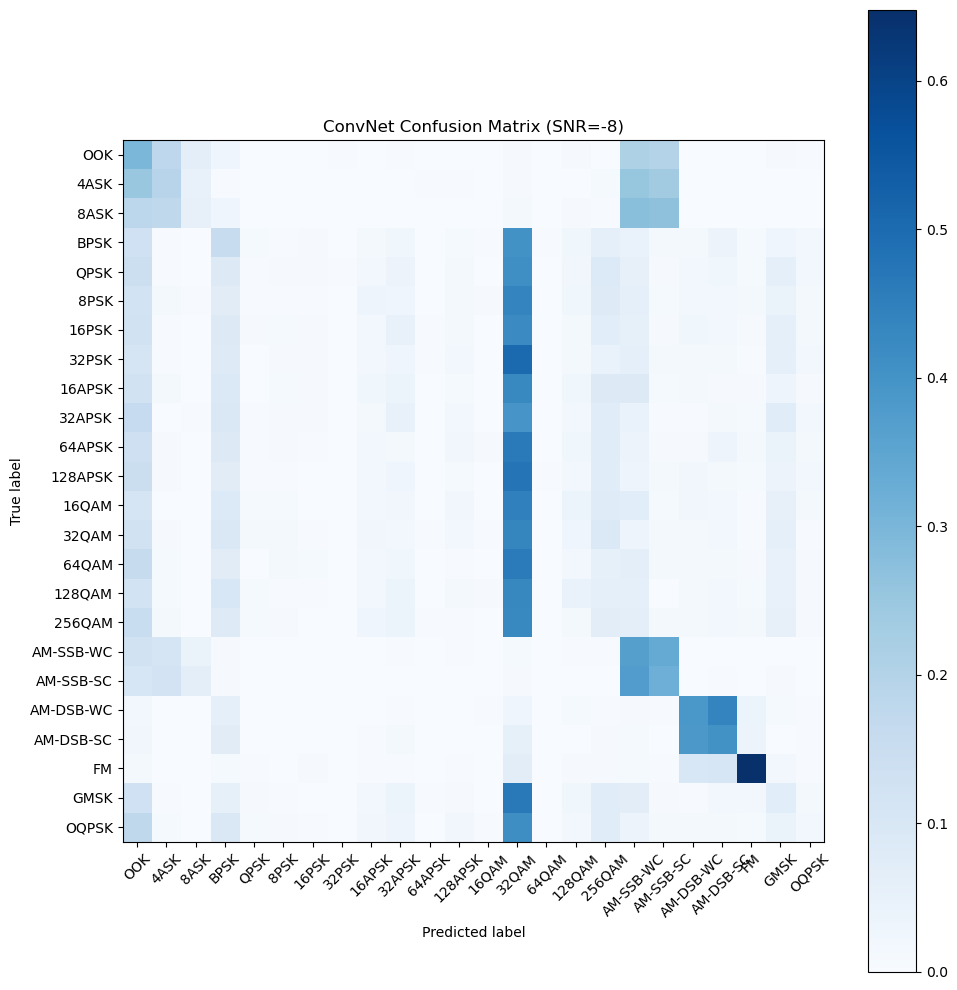

<Figure size 640x480 with 0 Axes>

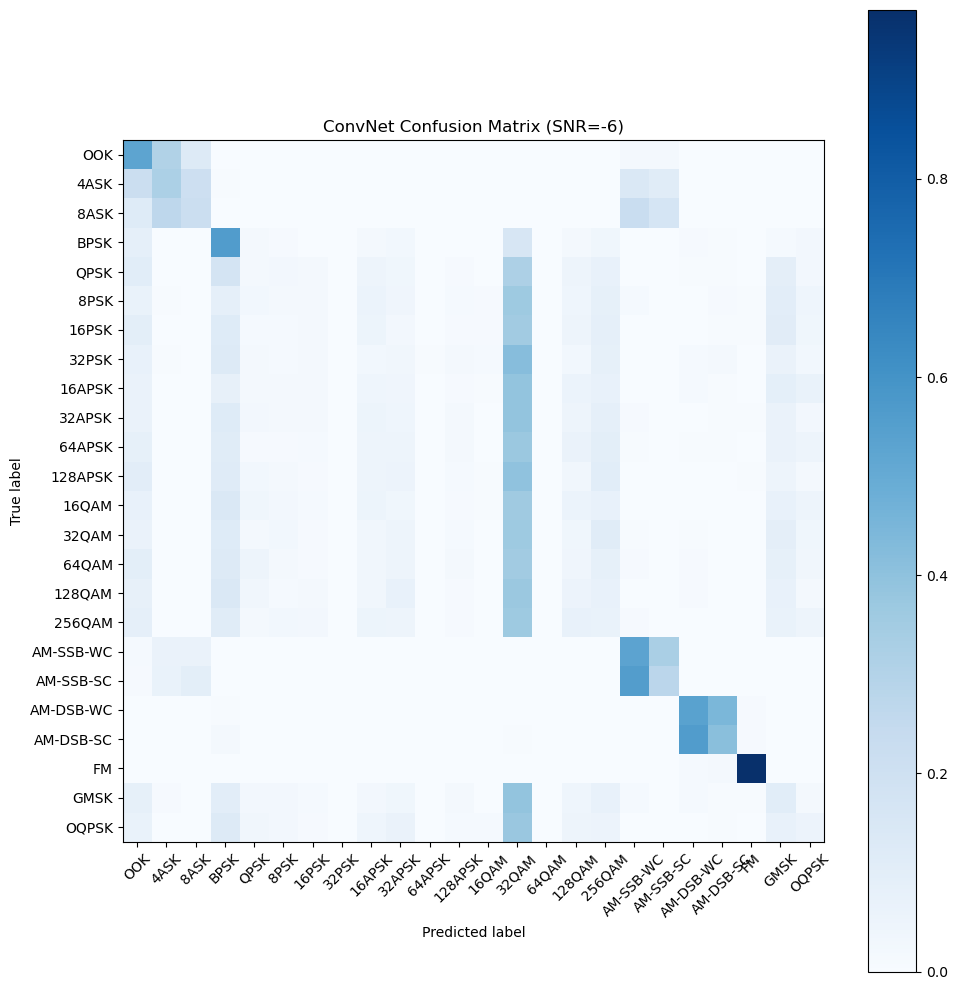

<Figure size 640x480 with 0 Axes>

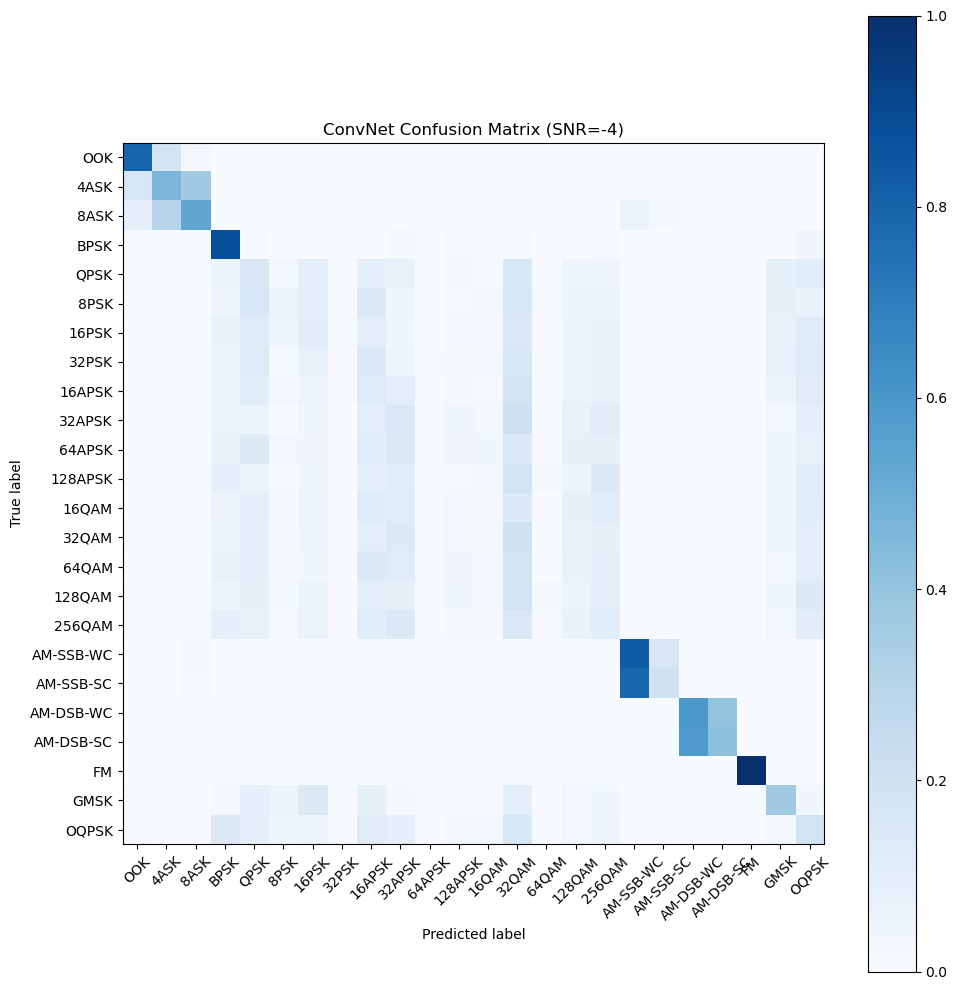

<Figure size 640x480 with 0 Axes>

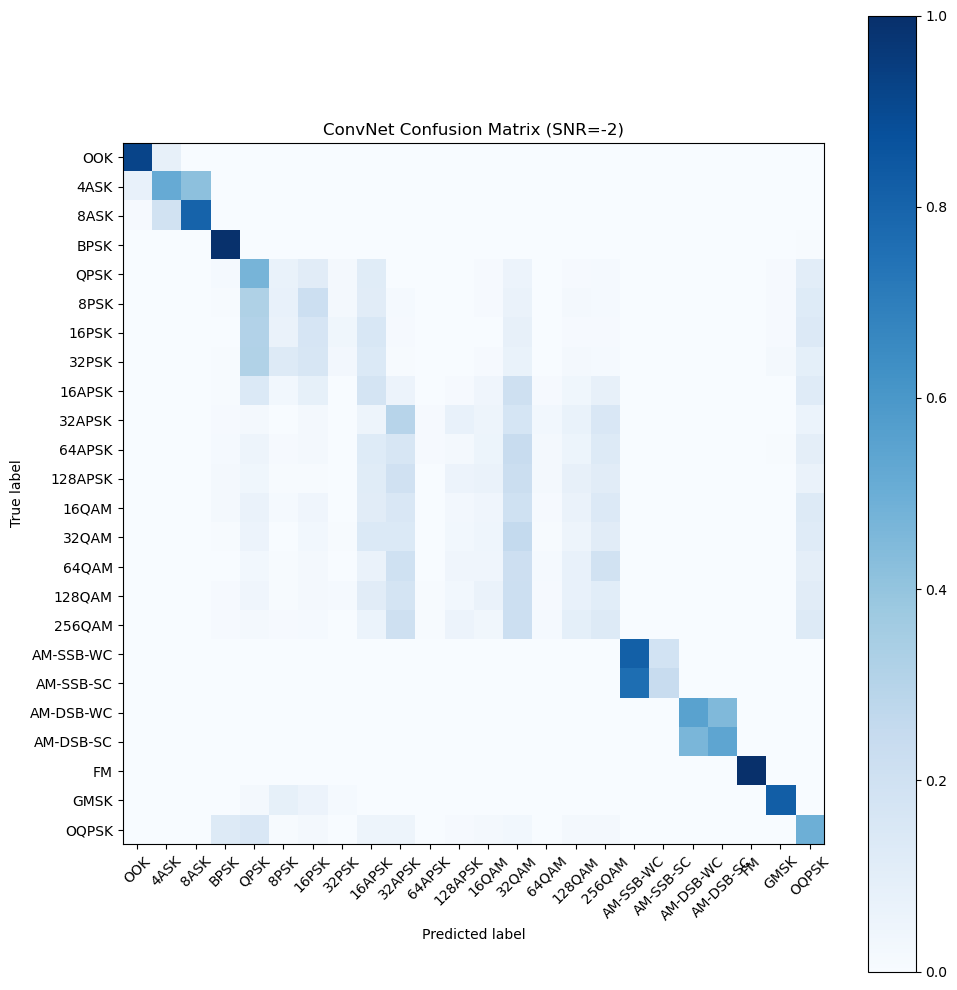

<Figure size 640x480 with 0 Axes>

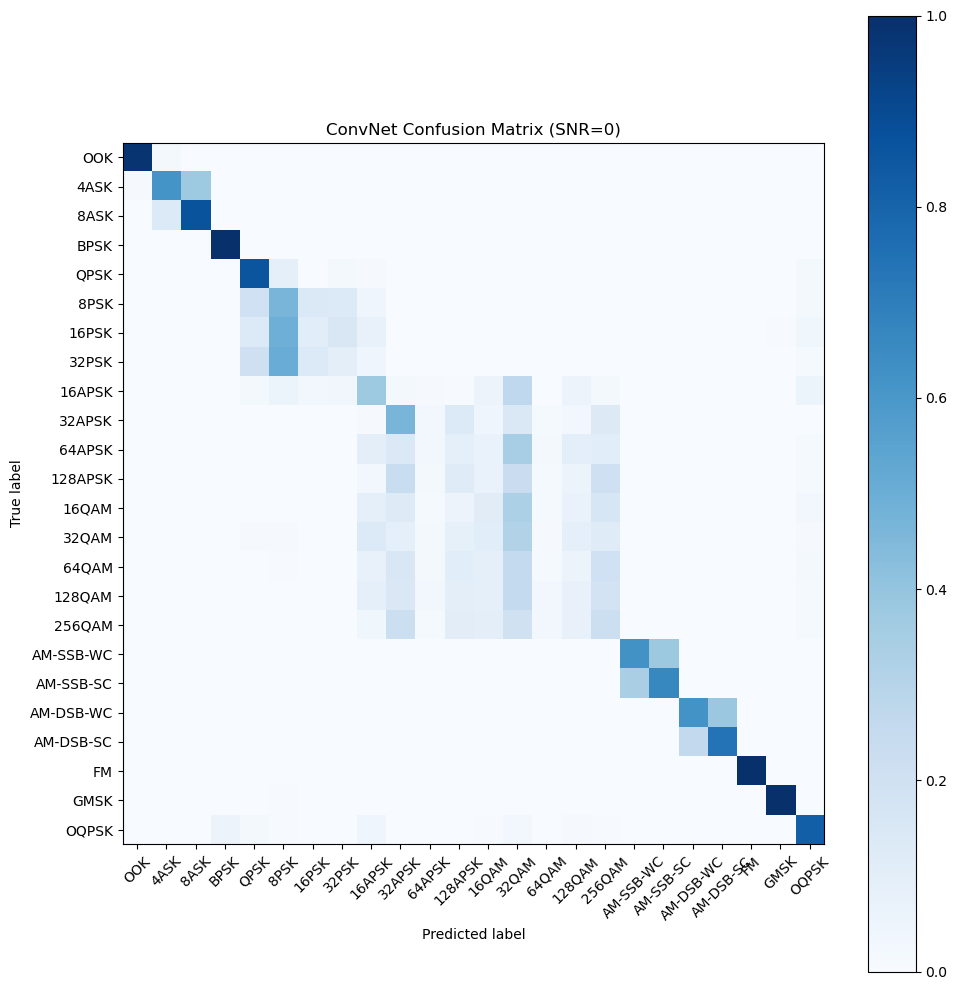

<Figure size 640x480 with 0 Axes>

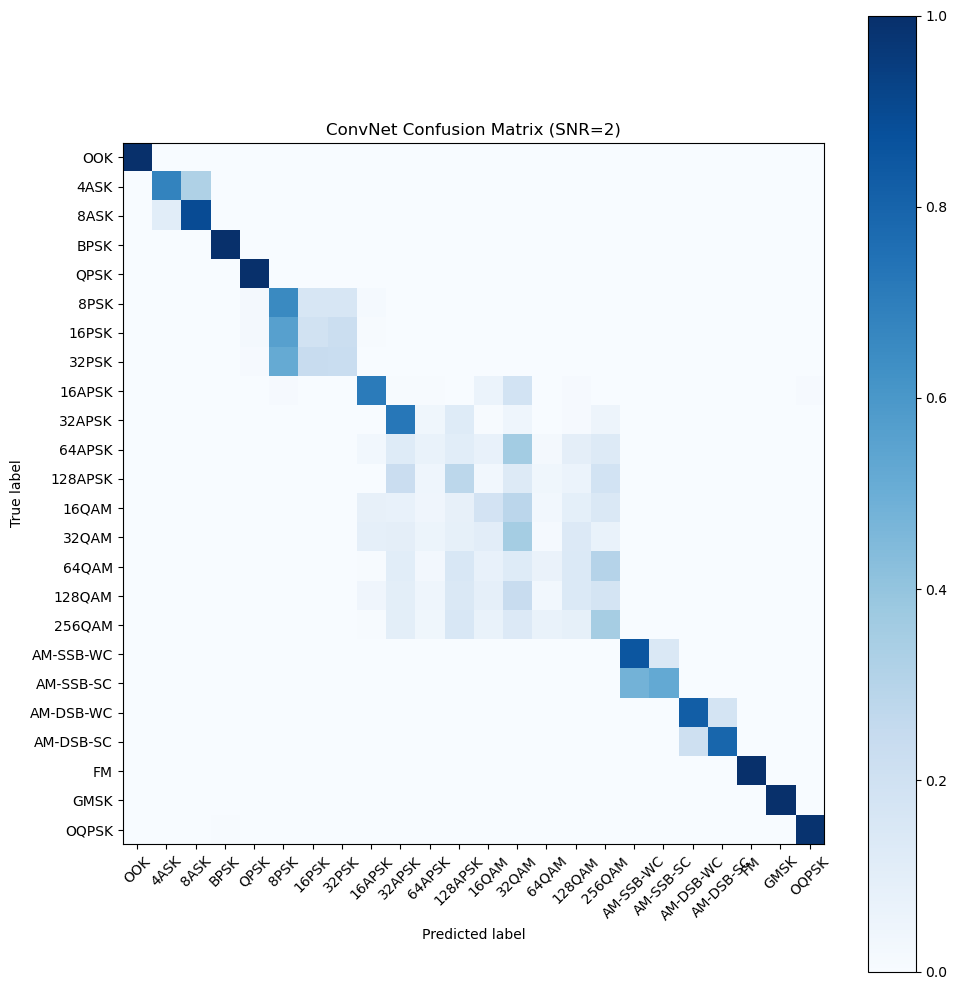

<Figure size 640x480 with 0 Axes>

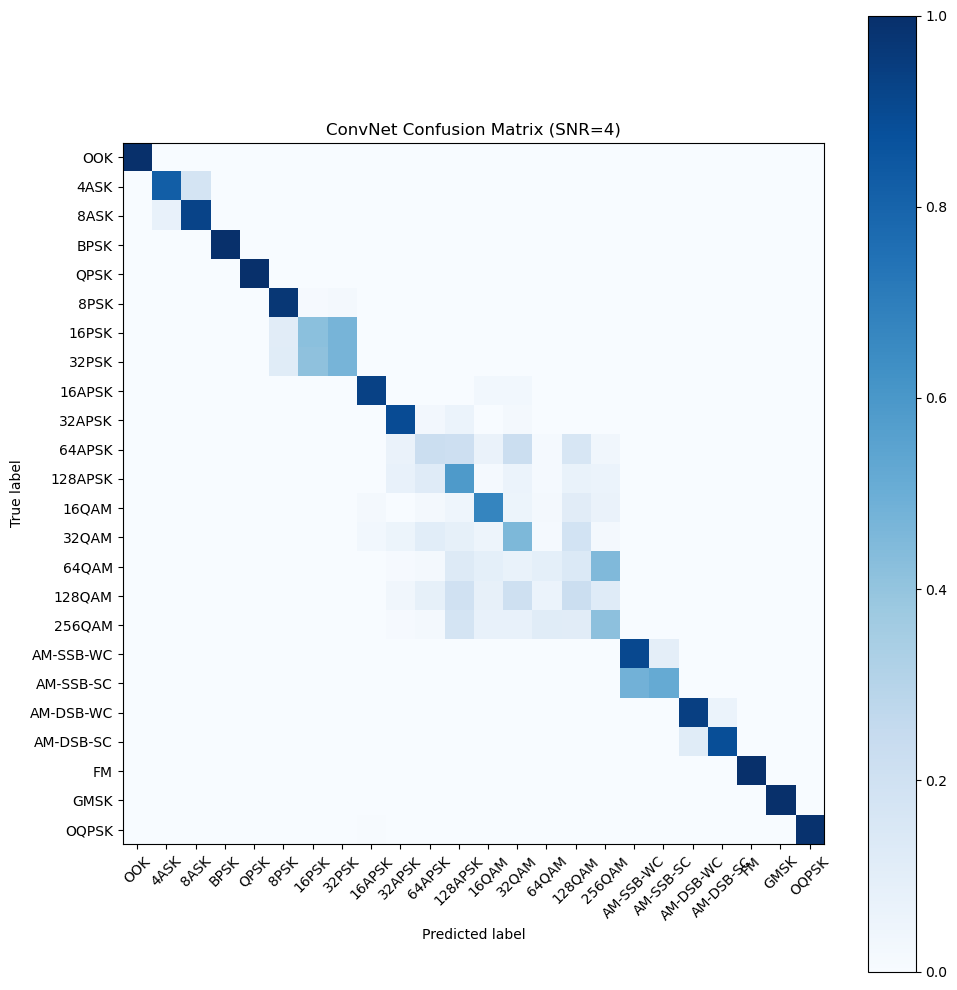

<Figure size 640x480 with 0 Axes>

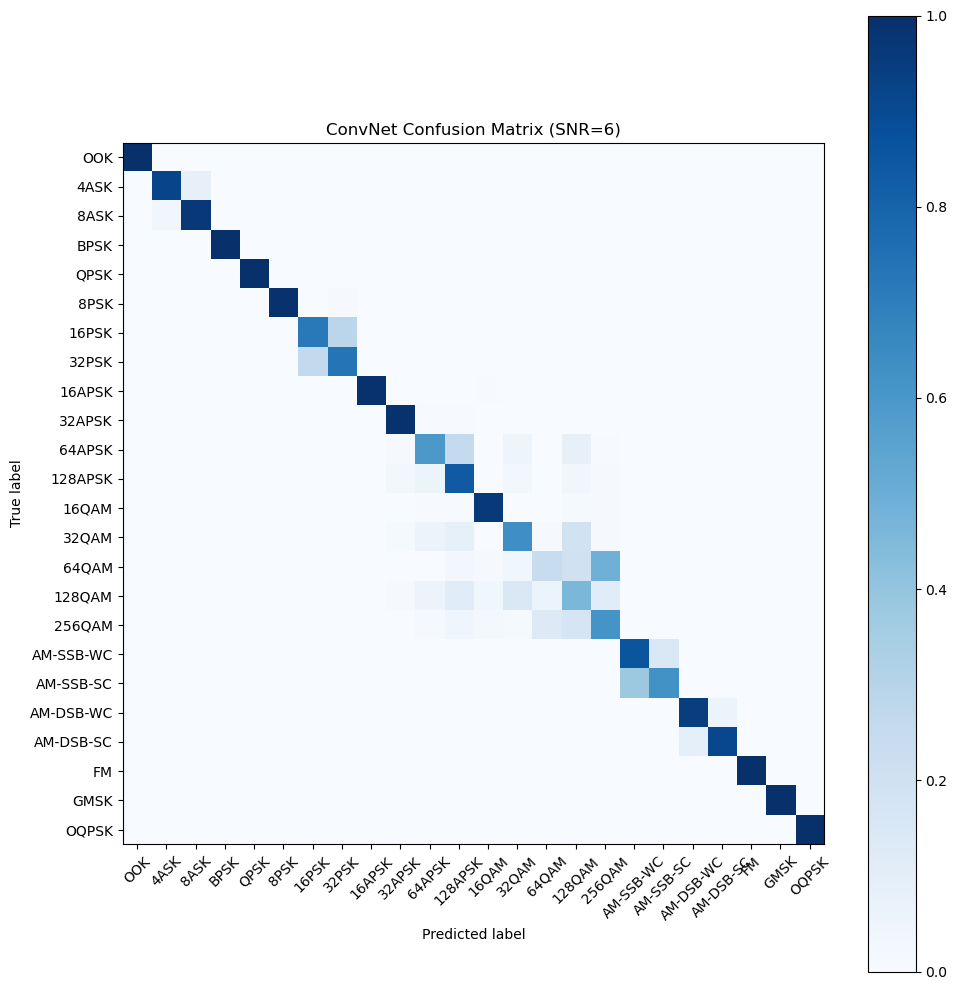

<Figure size 640x480 with 0 Axes>

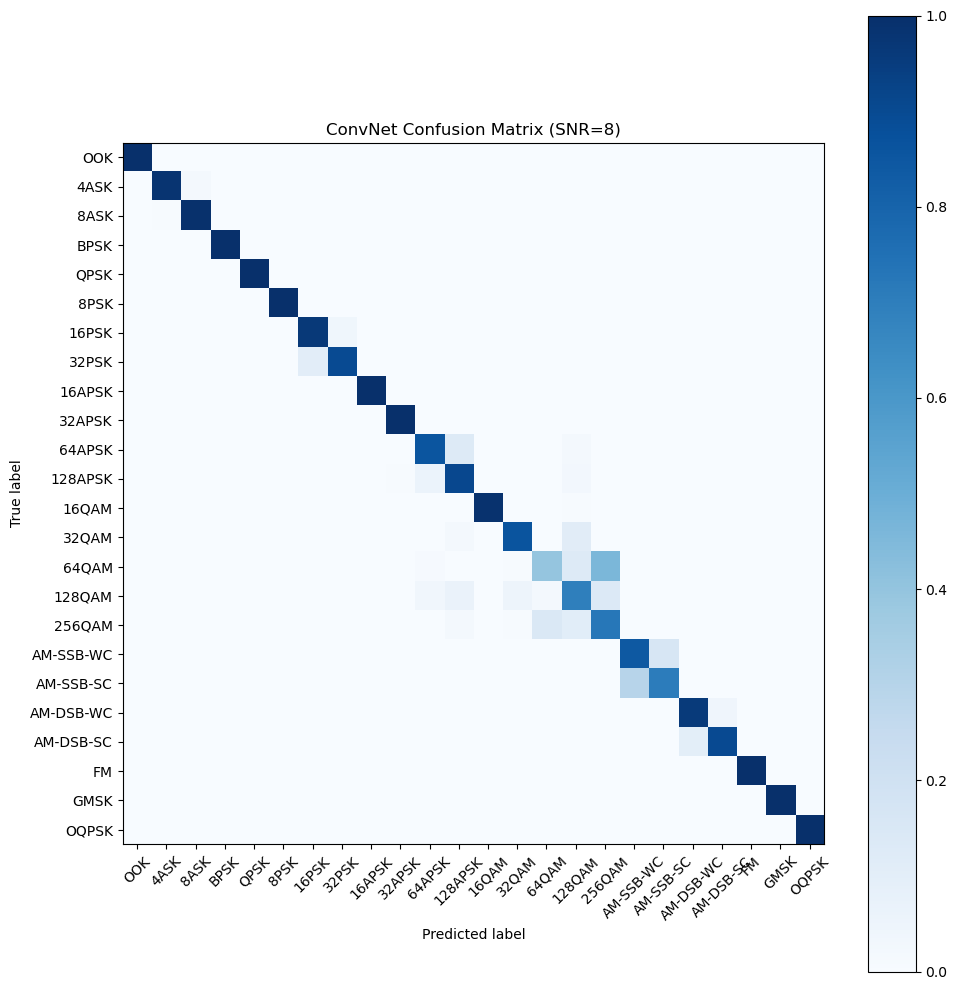

<Figure size 640x480 with 0 Axes>

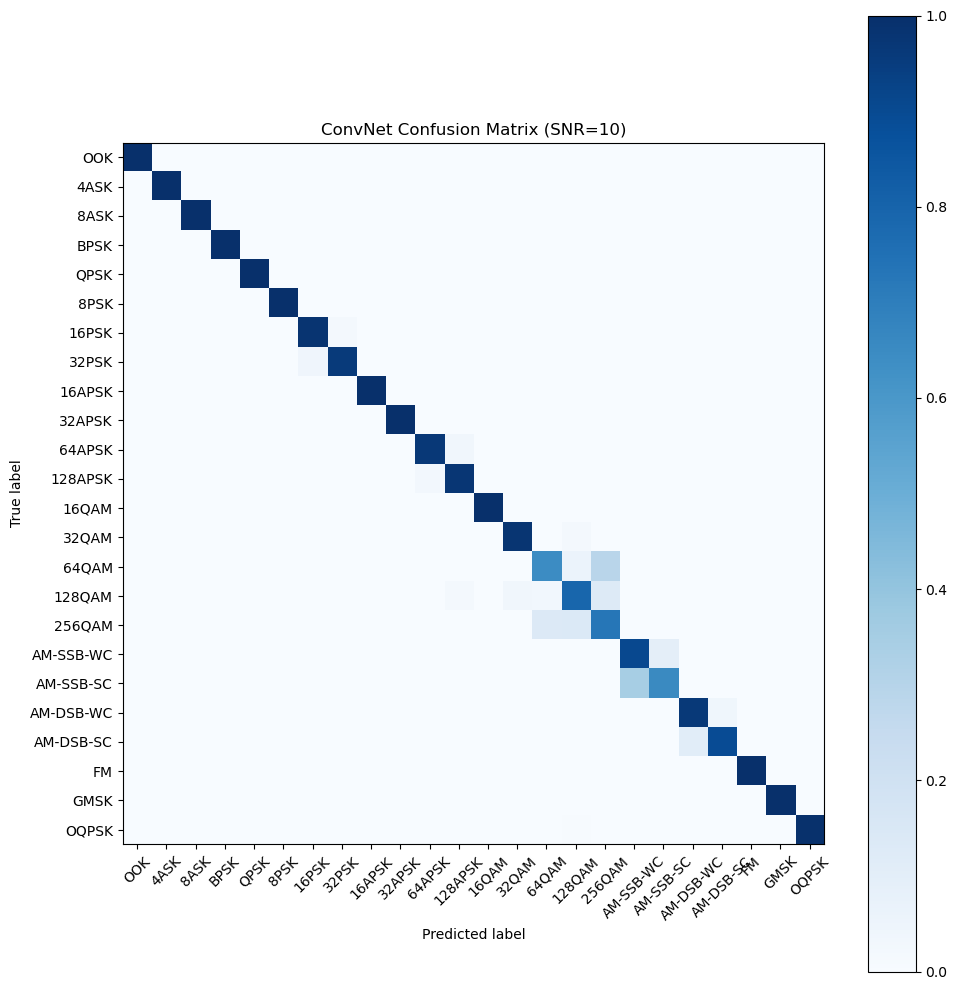

<Figure size 640x480 with 0 Axes>

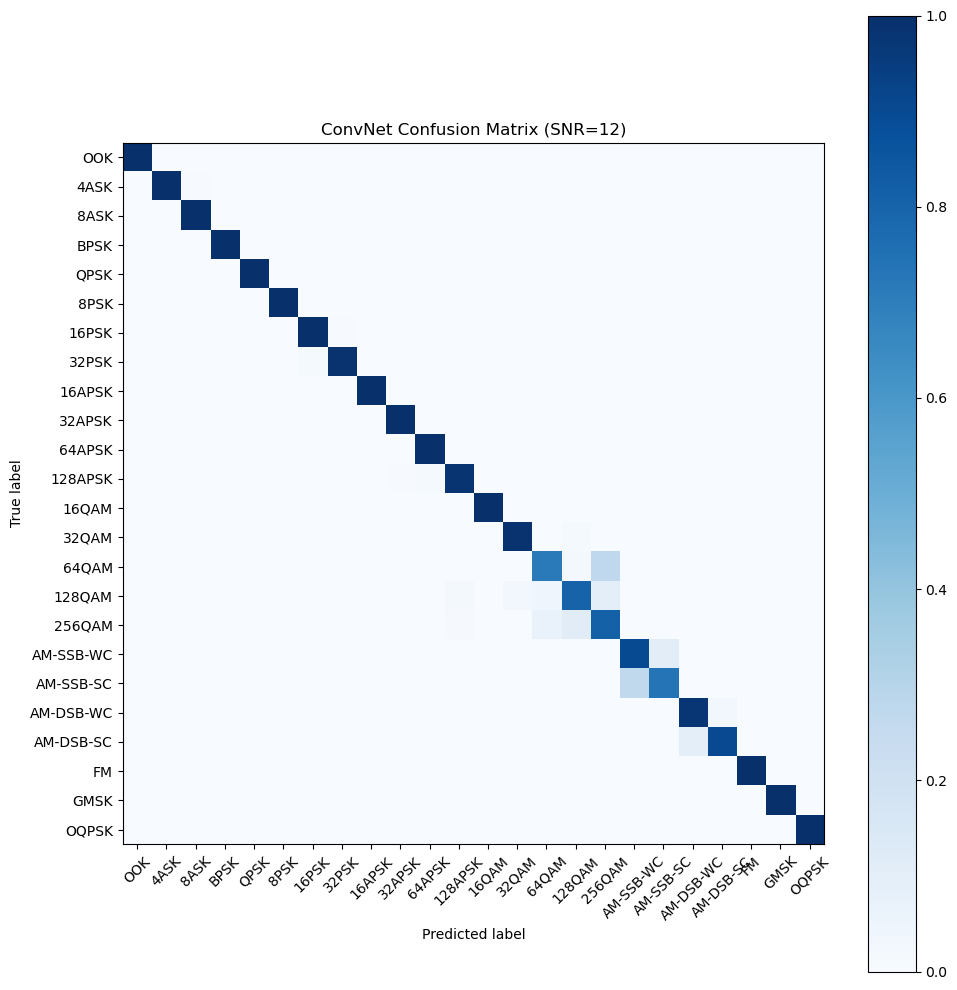

<Figure size 640x480 with 0 Axes>

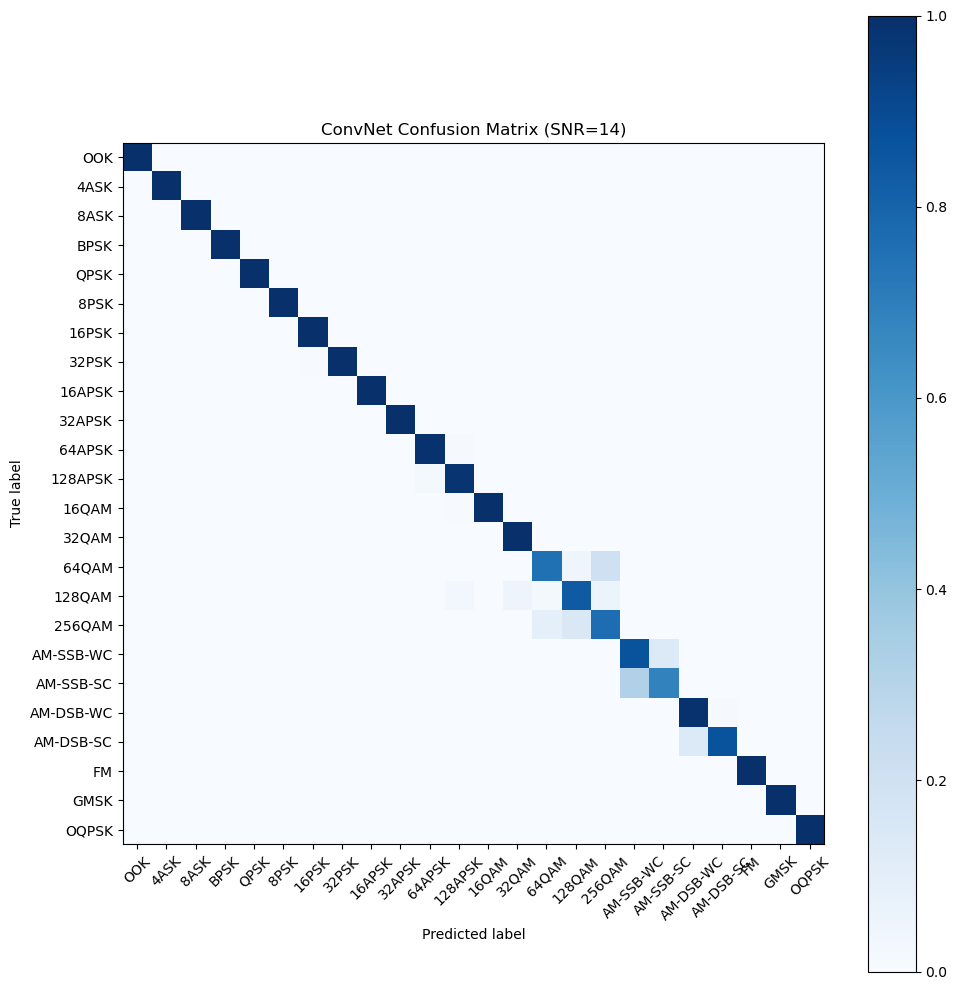

<Figure size 640x480 with 0 Axes>

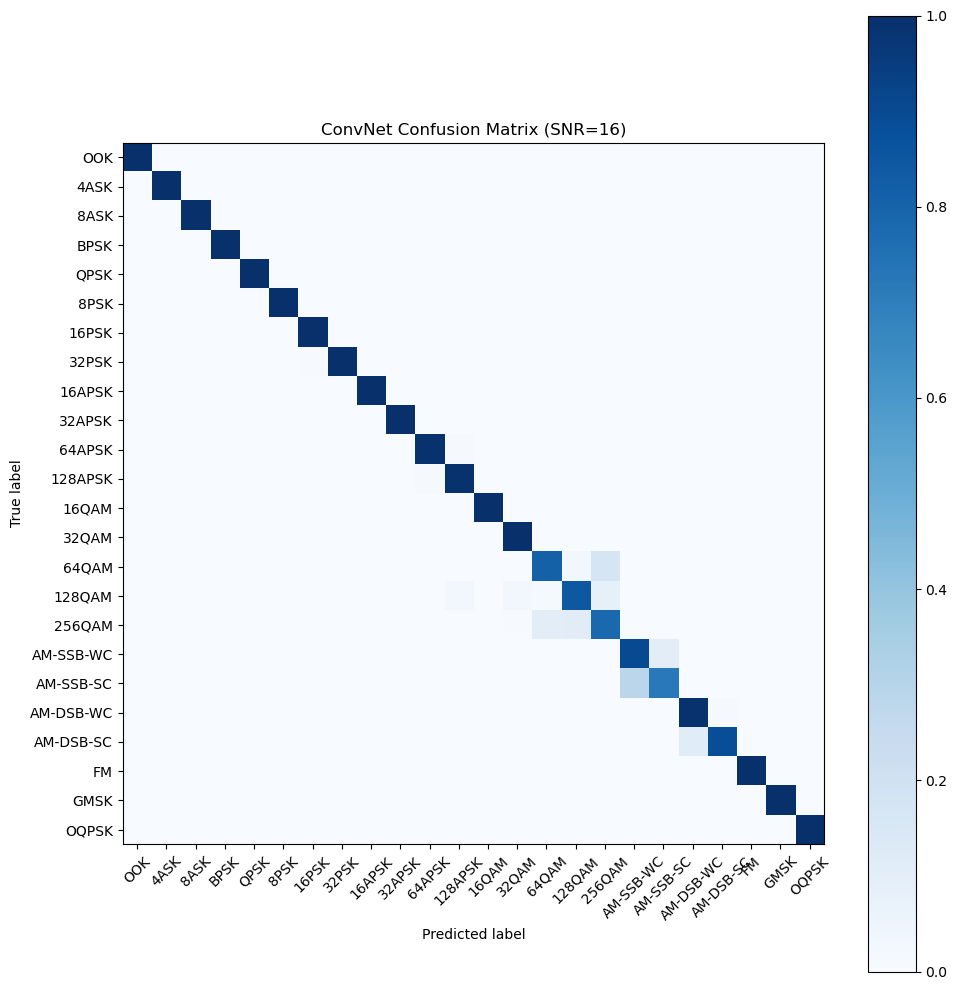

<Figure size 640x480 with 0 Axes>

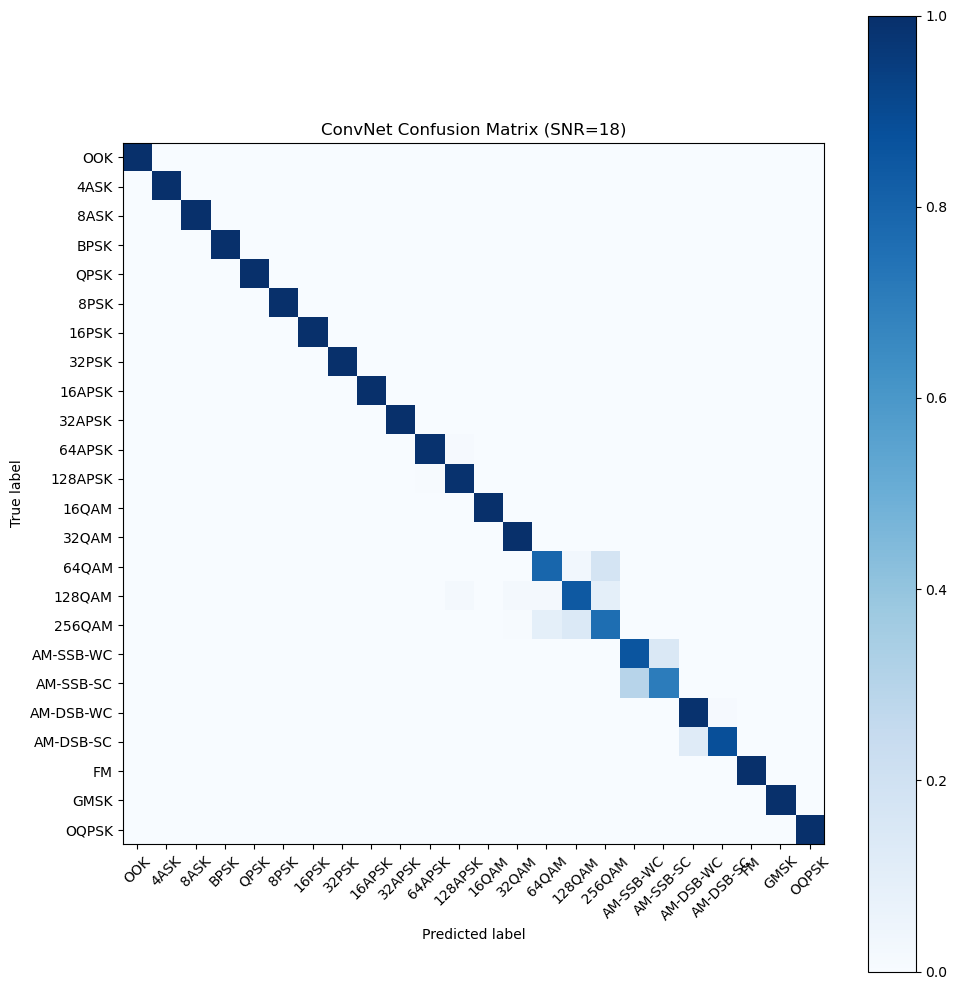

<Figure size 640x480 with 0 Axes>

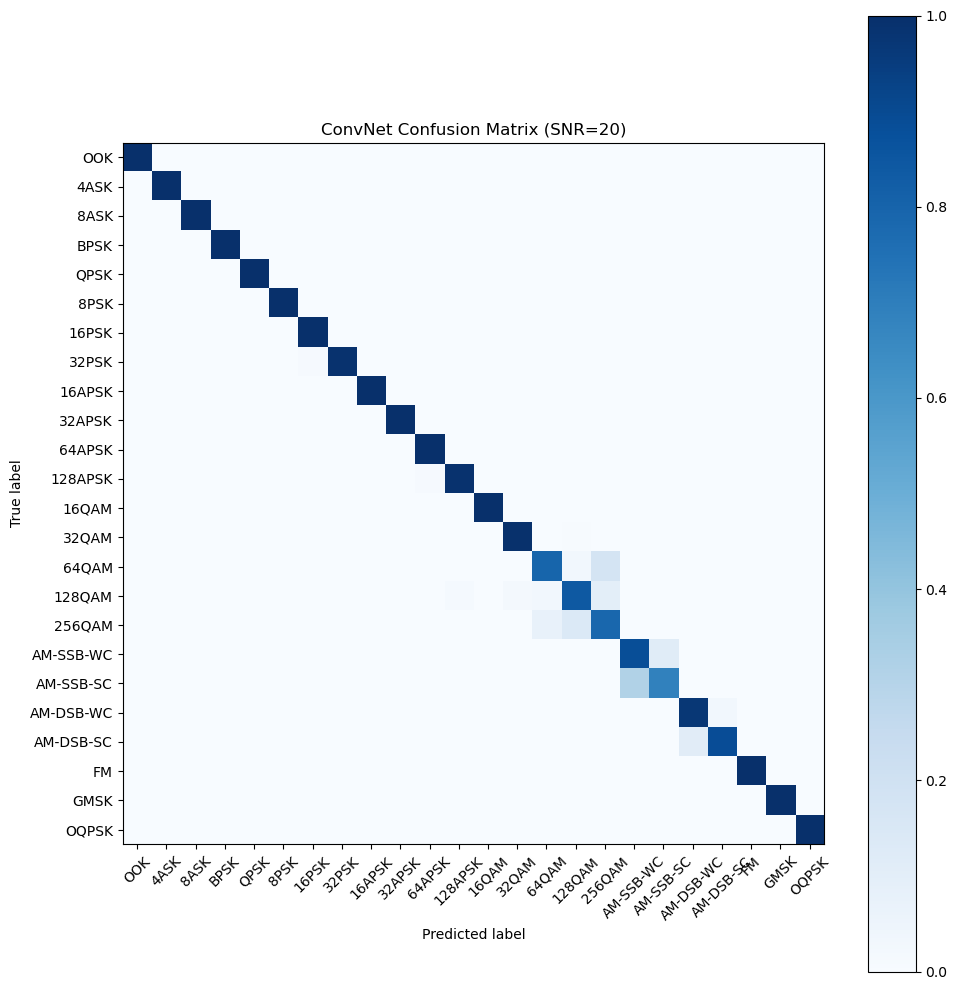

<Figure size 640x480 with 0 Axes>

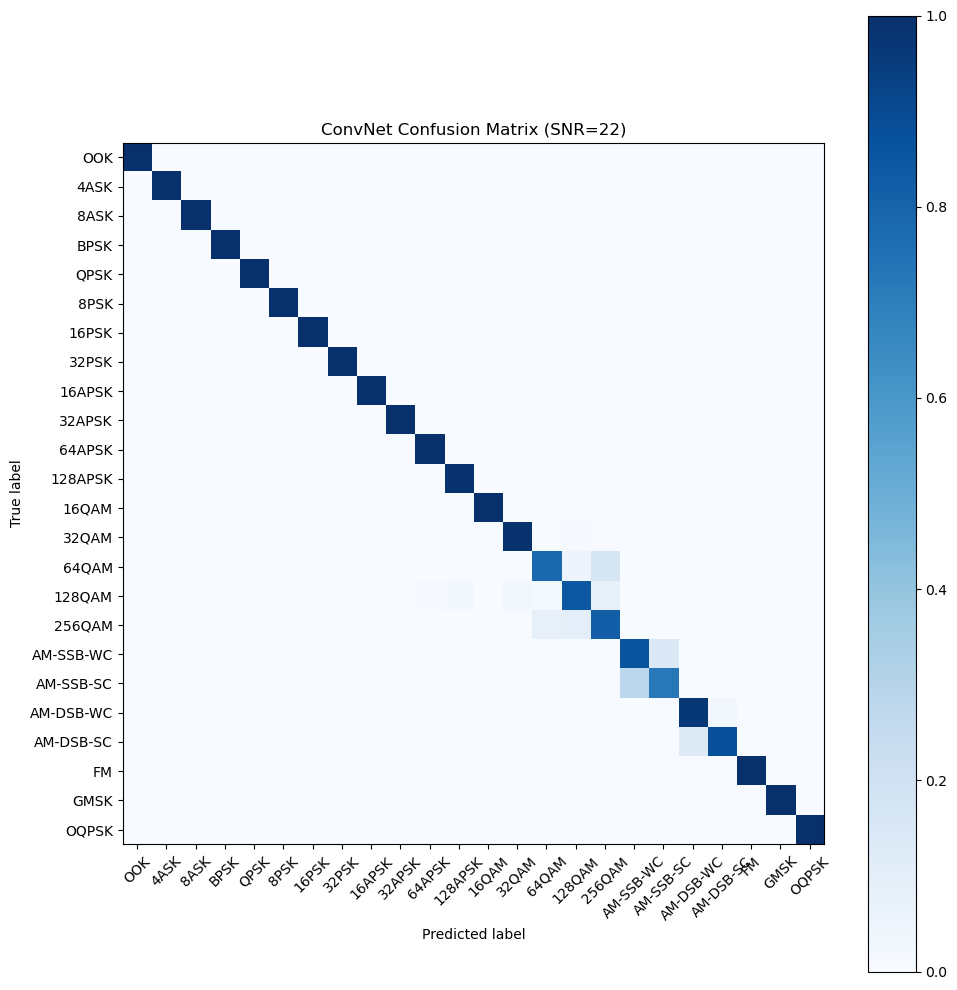

<Figure size 640x480 with 0 Axes>

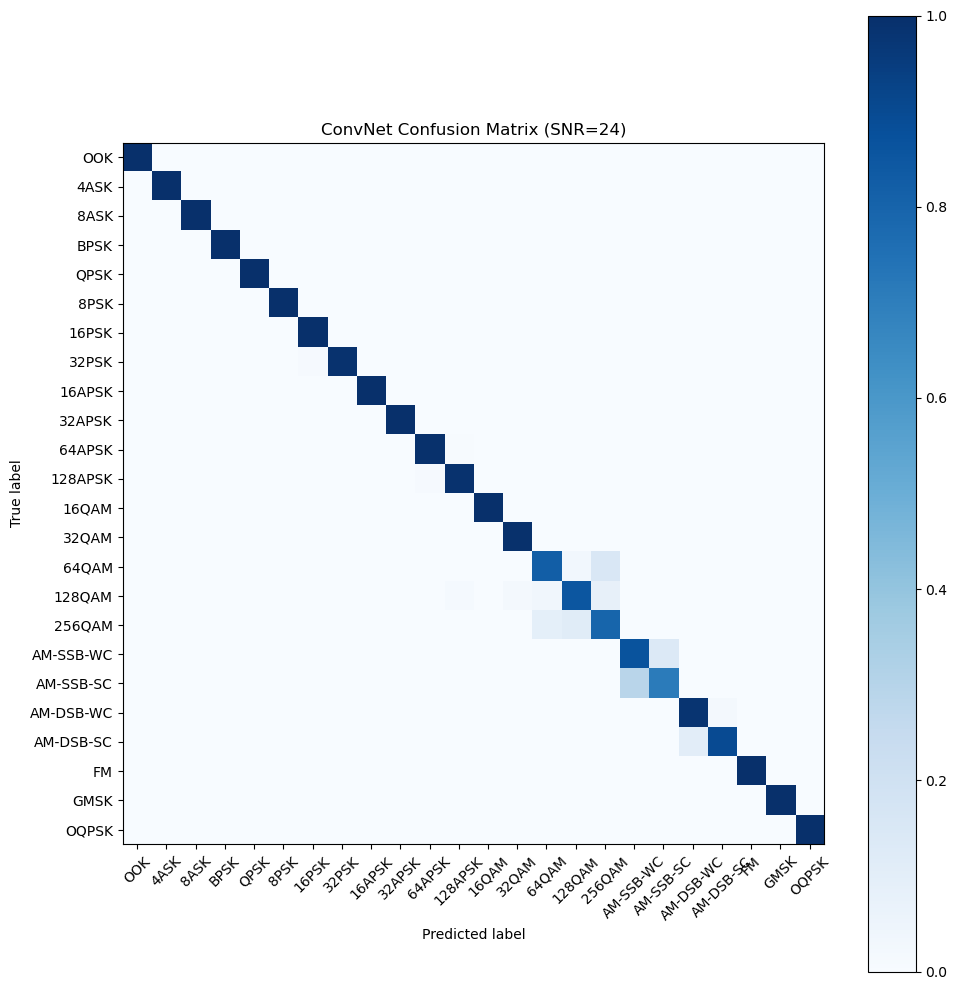

<Figure size 640x480 with 0 Axes>

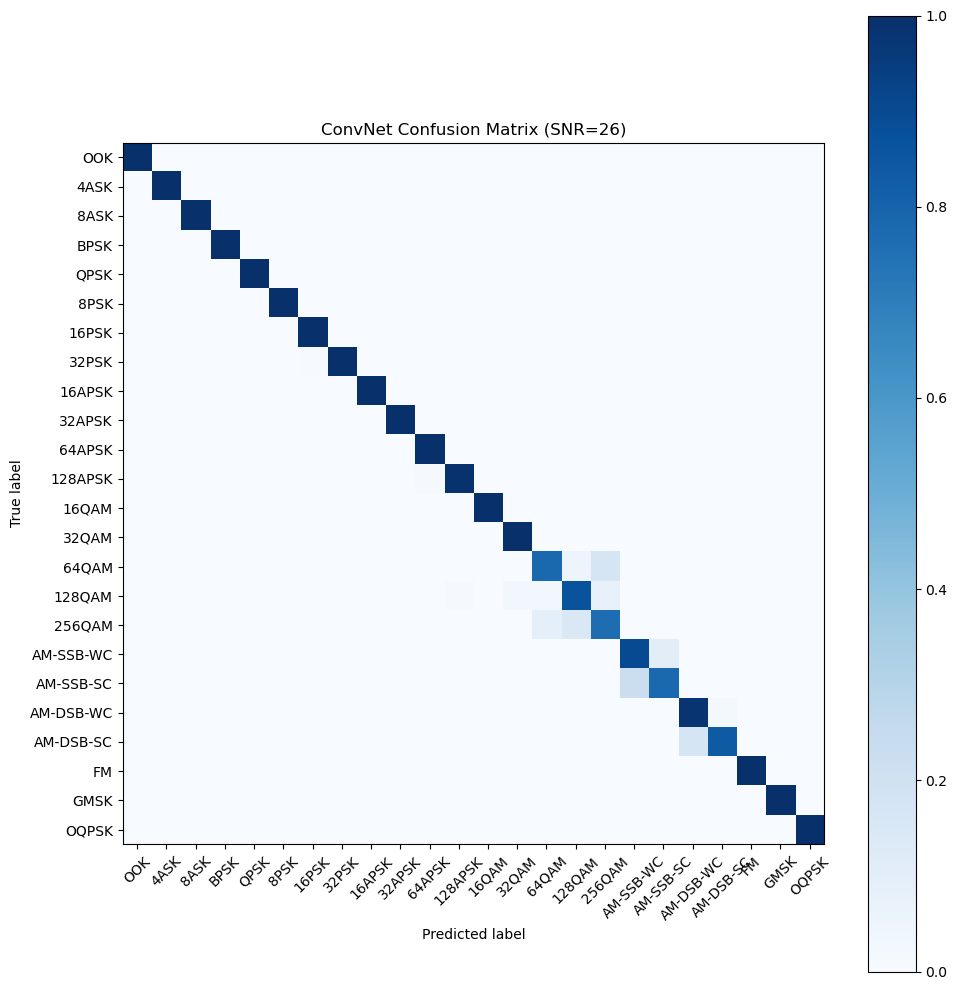

<Figure size 640x480 with 0 Axes>

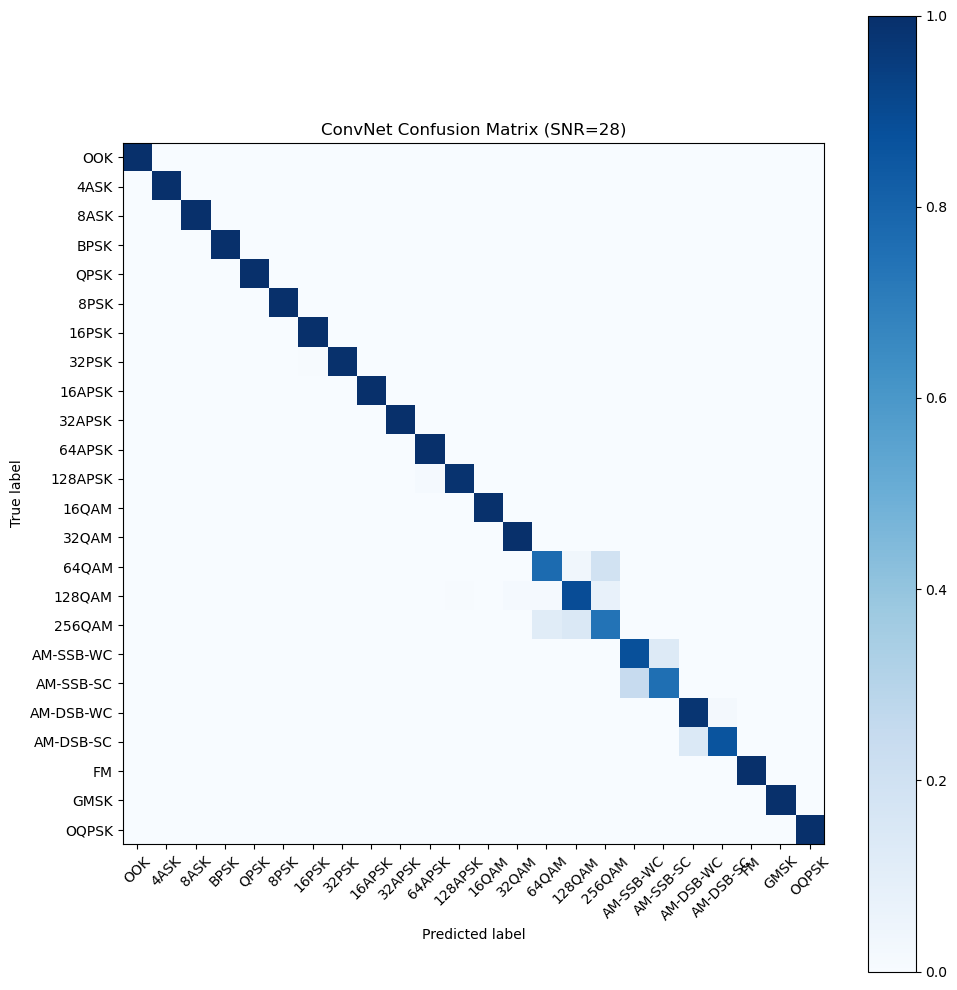

<Figure size 640x480 with 0 Axes>

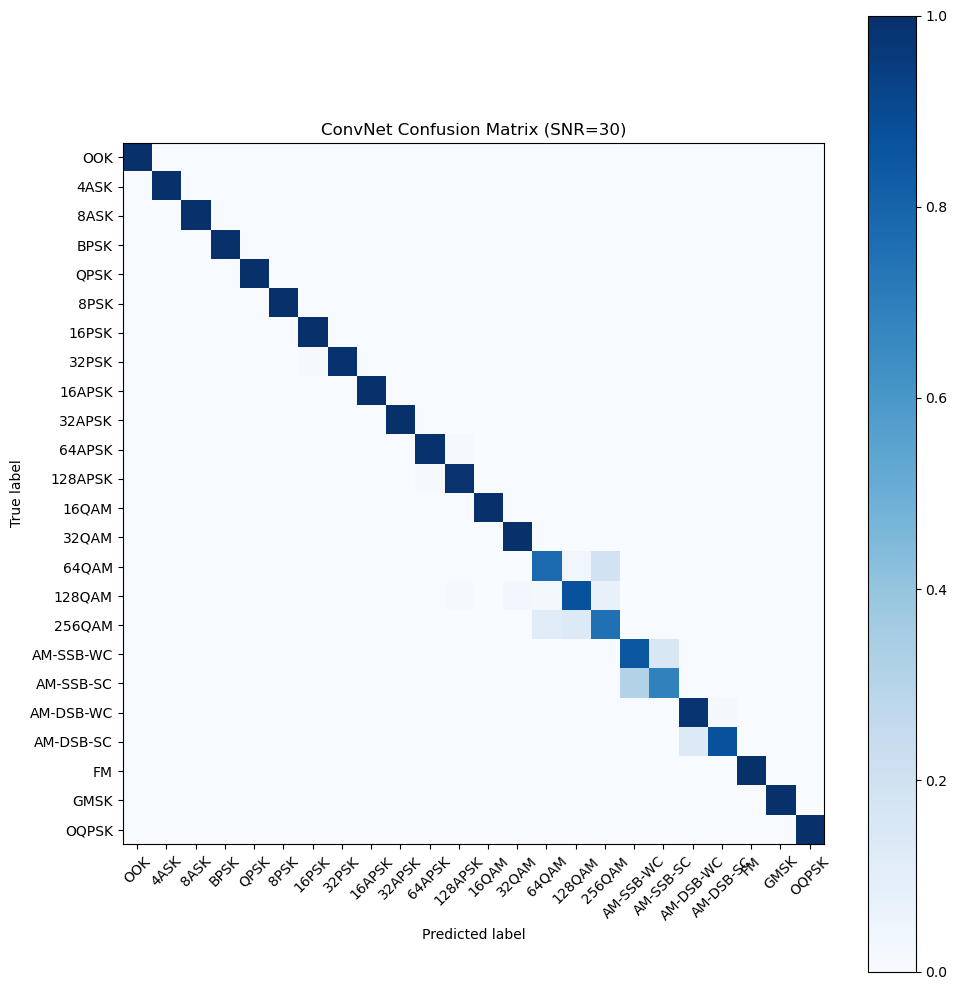

In [35]:
acc={}
Z_test = Z_test.reshape((len(Z_test)))
SNRs = np.unique(Z_test)
for snr in SNRs:
    X_test_snr = X_test[Z_test==snr]
    Y_test_snr = Y_test[Z_test==snr]
    
    pre_Y_test = model.predict(X_test_snr)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,X_test_snr.shape[0]):    #该信噪比下测试数据量
        j = list(Y_test_snr[i,:]).index(1)   #正确类别下标
        j = classes.index(classes[j])
        k = int(np.argmax(pre_Y_test[i,:])) #预测类别下标
        k = classes.index(classes[k])
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
   
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy %s: "%snr, cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

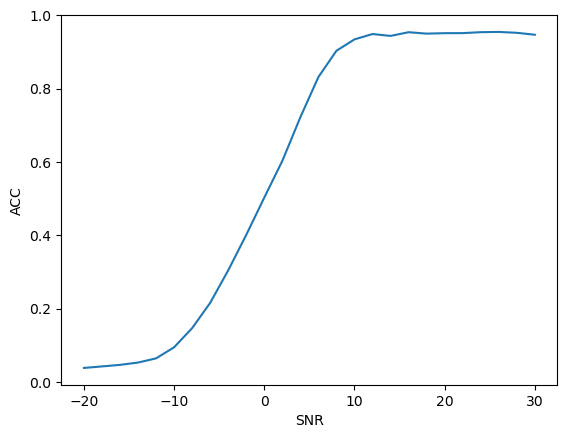

In [36]:
plt.plot(acc.keys(),acc.values())
plt.ylabel('ACC')
plt.xlabel('SNR')
plt.show()